# **PHASE 1 : TRAITEMENT DES IMAGES**

# **1 - Importation des bibliothèques**

In [1]:
import cv2 # pour afficher les images
import pandas as pd # pour manipuler les fichiers csv
import numpy as np # bibliothèque de l'algèbre linéaire
import matplotlib.pyplot as plt # pour le traçage des graphes
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split # pour fractionner les données
from tensorflow.keras.preprocessing.image import ImageDataGenerator # pour traiter les images

# **2 - Préparation des données**

**Visualisation du fichier csv**

In [2]:
csv_path = '../input/coronahack-chest-xraydataset/Chest_xray_Corona_Metadata.csv' 
train_path = '../input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/' 
test_path = '../input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/'

In [3]:
data = pd.read_csv(csv_path) # pour accéder au fichier csv
data

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN
...,...,...,...,...,...,...
5905,5928,person1637_virus_2834.jpeg,Pnemonia,TEST,NaN,Virus
5906,5929,person1635_virus_2831.jpeg,Pnemonia,TEST,NaN,Virus
5907,5930,person1634_virus_2830.jpeg,Pnemonia,TEST,NaN,Virus
5908,5931,person1633_virus_2829.jpeg,Pnemonia,TEST,NaN,Virus


Il y a des informations inutiles pour notre objectif. De plus, la répartition des images est non équilibrée.

Je vais me contenter uniquement des noms des images et leur classe (label).

**Fractionnement et équilibrage des données**

In [4]:
Train = data[data['Dataset_type'] == 'TRAIN'].copy() # les données d'entrainement
Train = Train[['X_ray_image_name', 'Label']] 
Test = data[data['Dataset_type'] == 'TEST'].copy() # les données de prédiction
Test = Test[['X_ray_image_name', 'Label']]
Train, Valid = train_test_split(Train, test_size=0.2, stratify=Train['Label'], random_state=38) # les données d'entrainement et de validation

In [5]:
print('Train Data :')
print(Train['Label'].value_counts())
print('\n'+'Validation Data :')
print(Valid['Label'].value_counts())
print('\n'+'Test Data :')
print(Test['Label'].value_counts())

Train Data :
Pnemonia    3155
Normal      1073
Name: Label, dtype: int64

Validation Data :
Pnemonia    789
Normal      269
Name: Label, dtype: int64

Test Data :
Pnemonia    390
Normal      234
Name: Label, dtype: int64


**Visualisation des images**

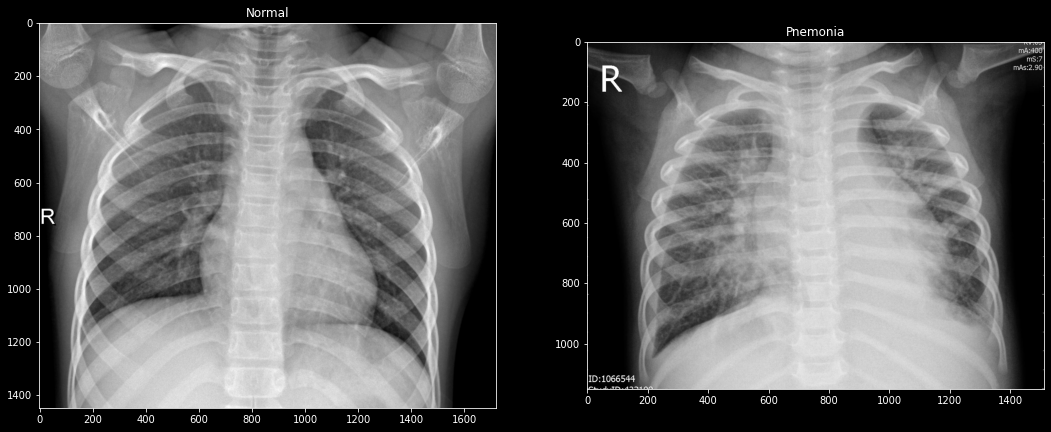

In [6]:
img1 = cv2.imread(train_path + data['X_ray_image_name'][1250])
img2 = cv2.imread(train_path + data['X_ray_image_name'][1966])

plt.style.use('dark_background')
plt.figure(figsize=(18,12))

plt.subplot(1,2,1)
plt.title(data['Label'][1250])
plt.imshow(img1)

plt.subplot(1,2,2)
plt.title(data['Label'][1966])
plt.imshow(img2)

plt.show()

> Les tailles des images sont différentes. Il faut appliquer une normalisation.

**Normalisation des images**

In [7]:
Generator_1 = ImageDataGenerator(rescale=1/255.)
Generator_2 = ImageDataGenerator( rescale = 1./255,
                                width_shift_range = 0.15,
                                height_shift_range = 0.15,
                                zoom_range = [0.9, 1.25],
                                brightness_range = [0.5, 1.5]
                                )  
targetSize = (224, 224) # la taille commune sera 224x224
batchSize = 32 # pour regrouper les images (32 images par groupe)
classMode = 'binary' # nous avons deux classes : 0 et 1
colorMode = 'rgb'  # rgb pour red/green/blue , 3 dimensions

Final_Train = Generator_2.flow_from_dataframe(
    dataframe = Train,
    directory = train_path,
    x_col = 'X_ray_image_name',
    y_col = 'Label',
    target_size = targetSize, 
    batch_size = batchSize,
    class_mode = classMode, 
    color_mode = colorMode,
    shuffle = True # reorganniser les images 
    )

Final_Valid = Generator_1.flow_from_dataframe(
    dataframe = Valid,
    directory = train_path,
    x_col = 'X_ray_image_name',
    y_col = 'Label',
    target_size = targetSize, 
    batch_size = batchSize,
    class_mode = classMode, 
    color_mode = colorMode,
    shuffle = True
    )

Final_Test = Generator_1.flow_from_dataframe(
    dataframe = Test,
    directory = test_path,
    x_col = 'X_ray_image_name',
    y_col = 'Label',
    target_size = targetSize, 
    batch_size = batchSize,
    class_mode = classMode, 
    color_mode = colorMode,
    shuffle = True
    )

Found 4228 validated image filenames belonging to 2 classes.
Found 1058 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


> Final_Test : tuple qui contient 20 blocs, chaque blocs contient une matrice de taille 32x224x224x3 et une matrice de taille 32x1 (labels)
...

# **PHASE 2 : ENTRAINEMENT**

# **1 - Importation des bibliothèques**

In [8]:
# Pour l'apprentissage profond
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
import tensorflow_hub as tf_hub
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# **2 - Le choix des métriques**

In [9]:
metrics = ['accuracy',keras.metrics.Precision(name='precision')]
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]

2022-05-30 19:56:29.498641: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 19:56:29.590639: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 19:56:29.591402: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 19:56:29.592496: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

# **3 - Le modèle : DenseNet 121**

In [10]:
tf.random.set_seed(38)

densenet_model = DenseNet121(include_top = False)
densenet_model.trainable = False

inputs = keras.layers.Input(shape=(224, 224, 3), name = 'input_layer')
x = densenet_model(inputs, training = False)
x = keras.layers.GlobalMaxPooling2D()(x)
x = keras.layers.Dense(1, activation = 'sigmoid', name = 'output_layer')(x)
densenet_model = keras.Model(inputs, x)

densenet_model.compile(loss = 'binary_crossentropy',
                    optimizer = Adam(learning_rate = 5e-5),
                    metrics = metrics)
densenet_model.summary()

29097984/29084464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_max_pooling2d (Global (None, 1024)              0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 1,025
Non-trainable params: 7,037,504
_________________________________________________________________


In [11]:
densenet_history = densenet_model.fit(Final_Train,
                                    epochs = 30,
                                    validation_data = Final_Valid,
                                    steps_per_epoch = len(Final_Train),
                                    validation_steps = len(Final_Valid),
                                    callbacks = callbacks)

2022-05-30 19:56:37.231047: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-05-30 19:56:45.067246: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


133/133 [==============================] - 156s 1s/step - loss: 0.9627 - accuracy: 0.5759 - precision: 0.7227 - val_loss: 0.7604 - val_accuracy: 0.7098 - val_precision: 0.7548
Epoch 2/30
133/133 [==============================] - 104s 782ms/step - loss: 0.7774 - accuracy: 0.6679 - precision: 0.7537 - val_loss: 0.6791 - val_accuracy: 0.7344 - val_precision: 0.7725
Epoch 3/30
133/133 [==============================] - 104s 784ms/step - loss: 0.6706 - accuracy: 0.6987 - precision: 0.7728 - val_loss: 0.5820 - val_accuracy: 0.7628 - val_precision: 0.8057
Epoch 4/30
133/133 [==============================] - 104s 779ms/step - loss: 0.5592 - accuracy: 0.7429 - precision: 0.8050 - val_loss: 0.5335 - val_accuracy: 0.7788 - val_precision: 0.8164
Epoch 5/30
133/133 [==============================] - 103s 774ms/step - loss: 0.5089 - accuracy: 0.7673 - precision: 0.8220 - val_loss: 0.4827 - val_accuracy: 0.7930 - val_precision: 0.8345
Epoch 6/30
133/133 [==============================] - 102s 771ms

In [12]:
densenet_model.save("DenseNet_121.h5")

# **PHASE 3 : EVALUATION ET PREDICTION**

# **1 - La courbe d'apprentissage**

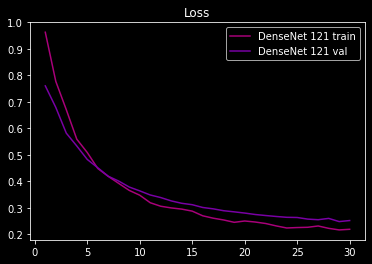

In [13]:
loss = densenet_history.history.get('loss')
val_loss = densenet_history.history.get('val_loss')
epochs = np.arange(1, len(densenet_history.history.get('loss')) + 1)

plt.plot(epochs, loss, color = '#a9007a')
plt.plot(epochs, val_loss, color = '#7900a5')
plt.legend(("DenseNet 121 train", "DenseNet 121 val"))
plt.title('Loss')
plt.show()

# **2 - La matrice de confusion**

In [14]:
i=0
y_true = []
for l in Final_Test:
    i+=1
    for x in l[1]:
        y_true.append(x)
    if i>=len(Final_Test):
        break

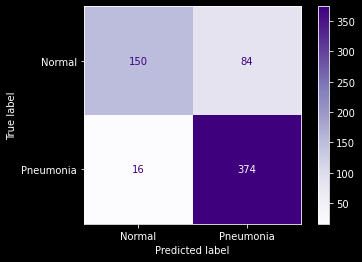

In [15]:
Final_Test.reset()

labels = ["Normal", "Pneumonia"]

densenet_predictions = densenet_model.predict(Final_Test)
y_pred = [1 if i > 0.5 else 0 for i in densenet_predictions]

densenet_matrix = confusion_matrix(y_true, y_pred)
densenet_disp = ConfusionMatrixDisplay(confusion_matrix=densenet_matrix, display_labels=labels)
densenet_disp.plot(cmap=plt.cm.Purples)
plt.show()

# **2 - Les scores**

In [16]:
Final_Test.reset()
score = densenet_model.evaluate(Final_Test) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

20/20 [==============================] - 6s 279ms/step - loss: 0.3756 - accuracy: 0.8397 - precision: 0.8166
Test loss: 0.3755856156349182
Test accuracy: 0.8397436141967773
